In [92]:
# setup matplotlib backend (to notebook, if possible, or inline).  
from jupyter import setup_matplotlib_backend
plt_is_interactive = setup_matplotlib_backend()

In [93]:
# general imports
import os
import numpy as np
import scipy as sp

# plotting/animation imports
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.animation as animation 
from matplotlib.patches import Rectangle, Circle, Arrow
from matplotlib.transforms import Affine2D
rcParams['figure.figsize'] = (8, 5)
from IPython.display import HTML, display

# pydrake imports
from pydrake.all import (SymbolicVectorSystem, LogOutput, Variable, Simulator, 
                         MathematicalProgram, IpoptSolver, PiecewisePolynomial, AutoDiffXd)
from pydrake.solvers.mathematicalprogram import GetInfeasibleConstraints
from pydrake.symbolic import if_then_else, logical_and, logical_or
from pydrake.common.containers import EqualToDict
from pydrake.symbolic import Expression, abs, cos, sin, tan, sqrt
import pydrake.symbolic as sym

# Simulation Parameters

In [94]:
# simulation parameters
map_name = "width_varied_river" 
""" MAP OPTIONS: 
    * no_current, 
    * downstream, 
    * upstream, 
    * diagonal_downstream, 
    * diagonal_upstream,
    * leftside_stream,
    * rightside_stream
    * WHIRLPOOL!
    * width_varied_river
    
"""
pad_factor = 1.0 # affects how much we pad plot margins around trajectories (ensures we're always centered/zoomed into trajectory)
num_curr_x = 10 # number of currents plotted along x
num_curr_y = 10 # number of currents plotted along y
duration = 90 # timesteps (must be bigger than 30) (NOTE: make this long enough to feasibily traverse your desired trajectory)
time_interval = 0.5 # seconds between control action
run_trajectory_optimization = True # whether or not to run trajectory optimization
run_simulation = False # whether or not to run the simulated dynamics
save_plots = True # whether or not to save all videos/plots to a folder @ "./results"

# general parameters
start = [0, 0, np.pi/4, 0, 0, 0] # initial state [x, y, theta, x_dot, y_dot, theta_dot] (always use np.pi instead of -np.pi)
target =[50, 60, np.pi, 0, 0, 0] # goal state [x', y', theta', x_dot', y_dot', theta_dot'] (always use np.pi instead of -np.pi)

# optimization parameters
thrust_lim = [10000, np.pi/2.75] # limits on force and angle
final_tolerances = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] # optimization tolerances for goal state constraint (x, y, th, x_dot, y_dot, th_dot)
dynamics_tolerances = [0.0, 0.0, 0.0, 0.1, 0.1, 0.1] # optimization tolerances for the dynamics constraint
eps = 0.1 # smoothing factor, allows differentiability: abs(x) ~ sqrt(x*x + eps)

# system constants
m = 10000 # mass of the boat [kg]
l = 8.0 # half length of the boat [m]
w = 5.0 # width of the boat [m]
h = 1.0 # heigh of boat under water [m]
rho_w = 1000.0 # density of water [kg/m^3]
d = 7 # torque drag lever arm length [m]
C_front = 0.05 # drag coeff of boat moving forward/back (streamlined body) [unitless]
C_side = 0.4 # drag coeff of boat moving sideways (half sphere) [unitless]

# define obstacles: obstacle = [[x_start, y_start]], [x_end, y_end], radius]
obstacle_params = np.array([
#                             [[10,5], [13,40], 5], 
#                             [[20,10], [40,10], 3],
#                             [[25, 17], [25, 17], 5]
                           ])

# switches to turn trajectory optimization constraints on/off
opt_switches = [
    1, # 0: initial state constraint
    1, # 1: goal state constraint
    1, # 2: dynamics
    1, # 3: thrust limits
    1, # 4: obstacles
    0] # 5: distance cost (optional)

# witches to turn metric plotting of different variables on/off
metric_switches = [
    1, # plot x(t)
    1, # plot y(t)
    1, # plot theta(t)
    1, # plot x_dot(t)
    1, # plot y_dot(t)
    1, # plot theta_dot(t)
    1, # plot F_t (torque force)
    1] # plot theta_t (torque force heading)


# Dynamics

In [95]:
def drag_coeff_from_angle(angle, C_side, C_front):
    '''
    Takes a weighted average of the side drag coefficient and front/back drag
    coefficient. The weighting corresponds to angle = boat_heading for the
    y-direction coefficients, with the x-direction just being a 90 deg shift

    Currently assumes boat is symmetrical about both axes 
    '''
    method = np if isinstance(angle, AutoDiffXd) else sym # Check type for autodiff
    # X is the same as Y shifted by 90 degrees
    return C_front*method.cos(angle-np.pi/2)**2 + C_side*method.sin(angle-np.pi/2)**2, C_front*method.cos(angle)**2 + C_side*method.sin(angle)**2

def drag_area_from_angle(angle, A_side, A_front):
    '''
    Takes weighted average of boat areas across front and side using same
    convention as drag_coeff_from_angle
    '''
    method = np if isinstance(angle, AutoDiffXd) else sym # Check type for autodiff
    return A_front*method.cos(angle-np.pi/2)**2 + A_side*method.sin(angle-np.pi/2)**2, A_front*method.cos(angle)**2 + A_side*method.sin(angle)**2

def get_drag_params(th_h):
    '''
    From paper
    eps = 0.000001 (separate from optimization smoothing parameter)
    C_front = 0.02058*(l**2*w*h/(sqrt(x_dot**2 + y_dot**2)+eps))**(-1/8)
    '''
    A_side = 2*l*h
    A_front = w*h
    scale = 1.0 # current scaling
    C_x, C_y = drag_coeff_from_angle(th_h, C_side, C_front)
    A_x, A_y = drag_area_from_angle(th_h, A_side, A_front)

    return C_x*scale, C_y*scale, A_x, A_y

def get_current(x, y, name, vectorize=False, scale=1):
    '''
    Retrieve x and y current components at a specific coordinate. If vectorize is True,
    then assume x, y inputs are arrays and return a grid of currents along these coordinate
    ranges. Used for plotting the vector field.
    ''' 
    method = np if isinstance(x, AutoDiffXd) else sym # Check type for autodiff

    currents = {
        "downstream" : 
            [lambda x, y: 0, 
            lambda x, y: -1.0],
        "upstream" : 
            [lambda x, y: 0, 
            lambda x, y: 1.0],
        "diagonal_downstream" : 
            [lambda x, y: -1.0, 
            lambda x, y: -1.0],
        "diagonal_upstream" : 
            [lambda x, y: 1.0, 
            lambda x, y: 1.0],
        "leftside_stream" :
            [lambda x, y: 1.0,
            lambda x, y: 0],
        "rightside_stream" :
            [lambda x, y: -1.0,
            lambda x, y: 0],
        "no_current" :
            [lambda x, y: 0,
            lambda x, y: 0],
        "WHIRLPOOL!" :
            [lambda x, y: y/30,
            lambda x, y: x/30],
        "width_varied_river" :
            [lambda x, y: 0,
             lambda x, y: (30-x)/30*0.25]}


    if vectorize:
        x_curr = np.zeros((len(x), len(y)))
        y_curr = np.zeros((len(x), len(y)))
        for i in range(len(x)):
            for j in range(len(y)):
                xi = x[i]
                yj = y[j]
                x_curr[i][j] = currents[name][0](xi, yj)
                y_curr[i][j] = currents[name][1](xi, yj)
    else:
        x_curr = currents[name][0](x, y)
        y_curr = currents[name][1](x, y)
    
    return x_curr*scale, y_curr*scale
  
def generate_dynamics(state, torques, scale=1, env_name="no_current"):
    '''
    Generate continuous time dynamics: x_dot = f(x, u, t)
    '''
    method = np if isinstance(state[0], AutoDiffXd) else sym # Check type for autodiff
    
    F_t, th_t = torques
    x, y, th_h, x_dot, y_dot, th_dot = state

    x_dot_c, y_dot_c = get_current(x, y, env_name, scale=scale)
    # x_dot_c, y_dot_c = 0, 0

    # Drag coefficient is a function of heading
    C_drag_x, C_drag_y, A_drag_x, A_drag_y = get_drag_params(th_h)
    
    # F = coefficients*signed v^2
    F_drag_x = 0.5*rho_w*C_drag_x*A_drag_x*(x_dot_c - x_dot)*method.sqrt((x_dot_c - x_dot)*(x_dot_c - x_dot) + eps)
    F_drag_y = 0.5*rho_w*C_drag_y*A_drag_y*(y_dot_c - y_dot)*method.sqrt((y_dot_c - y_dot)*(y_dot_c - y_dot) + eps)
    # F_drag_x = 0
    # F_drag_y = 0

    # Drag from boat spinning (to stop from spinning infinitely fast)
    T_drag_omega = -0.25*rho_w*C_side*h*(l**4)*th_dot*method.sqrt(th_dot * th_dot + eps)
    # T_drag_omega = 0

    I = m*((2*l)**2 + w**2) / 12
    
    # TODO double check, add torque from current
    x_ddot = (F_t*method.sin(th_h + th_t) + F_drag_x) / m
    y_ddot = (F_t*method.cos(th_h + th_t) + F_drag_y) / m
    th_ddot = (-F_t*l*method.sin(th_t) + (F_drag_x*method.cos(th_h) - F_drag_y*method.sin(th_h))*d + T_drag_omega)/I
    # th_ddot = 0

    return np.array([x_dot, y_dot, th_dot, x_ddot, y_ddot, th_ddot])

In [96]:
# current variable
x_dot_c = Variable("x_dot_c")
y_dot_c = Variable("y_dot_c")

# state of the robot (standard cartesian)
x = Variable("x") # horizontal position
y = Variable("y") # vertical position
theta = Variable("theta") # angular position
x_dot = Variable("x_dot") # horizontal velocity
y_dot = Variable("y_dot") # vertical velocity
theta_dot = Variable("theta_dot") # angular velocity
state = np.array([x, y, theta, x_dot, y_dot, theta_dot])

# control torques
thrust = Variable("thrust") # thrust force
thrust_angle = Variable("thrust_angle") # thrust angle
torques = np.array([thrust, thrust_angle])

In [97]:
def create_boat(current_scale=1):
    boat = SymbolicVectorSystem(
              state=state,
              input=torques,
              output=state,
              dynamics=generate_dynamics(state, torques, current_scale, map_name)
          ) 
    return boat

boat =  create_boat()
boat2 = boat.ToAutoDiffXd()

In [98]:
class Obstacle:
    def __init__(self, start, end, radius, time_steps, time_interval):
        """
            Obstacle Moves from Start to End in simulation
            start: 2x1 (x, y)
            end: 2x1 (x,y)
            
            Example: Obstacle([0,0],[1,1], 5, duration, time_interval)
        """
        self.start = np.array(start).reshape(-1, 1)
        self.end = np.array(end).reshape(-1, 1)
        self.radius = radius
        self.traj = self.add_trajectory(time_steps, time_interval)
        
    def add_trajectory(self, time_steps, time_interval):
        '''
        Generate a starting trajectory guess by drawing a line from 
        start to target.
        '''
        # initial and final time and state
        time_limits = [0., time_steps * time_interval]
        position_limits = np.column_stack((self.start, self.end))

        # linear interpolation in state
        state = PiecewisePolynomial.FirstOrderHold(time_limits, position_limits)

        # sample state on the time grid
        return np.vstack([state.value(t * time_interval).T for t in range(time_steps+1)])

# Create Obstacle objects
obstacles = [Obstacle(x,y,r,duration,time_interval) for x,y,r in obstacle_params]

# Trajectory Optimization

In [99]:
def get_initial_guess(start, target, duration, time_interval):
    '''
    Generate a starting trajectory guess by drawing a line from 
    start to target, and inferring velocities required to trace
    that line.
    '''
    np.random.seed(1)
    xs, ys, ths , xs_dot, ys_dot, ths_dot = start
    xg, yg, thg, xg_dot, yg_dot, thg_dot = target
    
    #-------------------------- STATE TRAJECTORY GUESS  --------------------------#
    
    # initial and final times/states
    time_limits = [0., duration * time_interval]
    position_limits = np.column_stack((start[:2], target[:2]))
    
    # constant heading guess
    shift_x = (xg - xs) # center coordinates
    shift_y = (yg - ys)
    if shift_x == 0 and shift_y == 0:
        heading_guess = 0.0
    else:
        heading_guess = np.arccos(shift_y/np.sqrt(shift_x**2 + shift_y**2)) 
        if shift_x < 0:
            heading_guess = -heading_guess
    
    position_limits = np.vstack((position_limits, [heading_guess, heading_guess])) # add heading guess
    state_limits = np.vstack((position_limits, np.zeros((3, 2)))) # add zeroed out velocity guesses
    
    # linear interpolation in state
    state = PiecewisePolynomial.FirstOrderHold(time_limits, state_limits)

    # stack position guesses
    traj_guess = np.vstack([state.value(t * time_interval).T for t in range(duration+1)])
    
    # add constant velocity guesses
    x_dot_guess = (traj_guess[-1, 0] - traj_guess[0, 0])/((duration+1)*time_interval)
    y_dot_guess = (traj_guess[-1, 1] - traj_guess[0, 1])/((duration+1)*time_interval)
    th_dot_guess = 0.0
    
    for t in range(duration+1):
        traj_guess[t][3] = x_dot_guess
        traj_guess[t][4] = y_dot_guess
        traj_guess[t][5] = th_dot_guess
    
    #-------------------------- TORQUE INPUT GUESS  --------------------------#
    
    # thrust angle (turn towards, stay straight, then turn to final angle)
    initial_thrust_angle = -(heading_guess - ths)
    final_thrust_angle = (heading_guess - thg)
    if np.abs(initial_thrust_angle) > thrust_lim[1]: # enforce thrust angle limit
        initial_thrust_angle = np.sign(initial_thrust_angle)*thrust_lim[1]
    if np.abs(final_thrust_angle) > thrust_lim[1]:
        final_thrust_angle = np.sign(final_thrust_angle)*thrust_lim[1]
    thrust_headings = np.zeros(duration)
    thrust_headings[:10] = initial_thrust_angle
    thrust_headings[-10:] = final_thrust_angle
    
    # thrust force
    thrust_forces = np.zeros(duration)

    # stack torque guesses
    thrust_guess = np.column_stack((thrust_forces, thrust_headings))

    return traj_guess, thrust_guess
    

In [100]:

def formulate_optimization(environment_name):
    '''
    Generate and return an optimization problem. All decision variables,
    constraints, and costs are added here.
    '''
    
    def discrete_dynamics(state, state_next, thrust):
        '''Forward euler method to approximate discretized dynamics'''
        state_dot = generate_dynamics(state, thrust, env_name=environment_name)
        residuals = state_next - state - time_interval*state_dot
        return residuals
    
    def squared_distance_to_obstacle(boat_pos, obs_pos):
        '''Compute the squared distance from the boat to an obstacle'''
        vec = boat_pos - obs_pos
        return vec.dot(vec)
    
    # initialize optimization
    prog = MathematicalProgram()
    opt_state = prog.NewContinuousVariables(duration + 1, 6, 'optimal_state')
    opt_thrust = prog.NewContinuousVariables(duration, 2, 'optimal_thrust')

    if opt_switches[0]:
        # initial state constraint
        for i in range(len(start)):
            prog.AddConstraint(opt_state[0, i] - start[i], 0., 0.).evaluator().set_description("Initial State")

    if opt_switches[1]:
        # goal state constraint
        for i in range(len(start)):
            prog.AddConstraint(opt_state[-1, i] - target[i], -final_tolerances[i], final_tolerances[i]).evaluator().set_description(f"Final State {i}")

    if opt_switches[2]:
        # enforce dynamics
        for t in range(duration):
            residuals = discrete_dynamics(opt_state[t], opt_state[t+1], opt_thrust[t])
            for i, residual in enumerate(residuals):
                prog.AddConstraint(residual, -dynamics_tolerances[i], dynamics_tolerances[i])

    if opt_switches[3]:
        # thrust limits
        for t in range(duration):
            prog.AddConstraint(opt_thrust[t][0], -thrust_lim[0], thrust_lim[0])
            prog.AddConstraint(opt_thrust[t][1], -thrust_lim[1], thrust_lim[1])

    if opt_switches[4]:
        # avoid collisions
        for i, obstacle in enumerate(obstacles):
            for t in range(duration+1):
                d2 = squared_distance_to_obstacle(opt_state[t, 0:2], obstacle.traj[t])
                prog.AddConstraint(d2 >= obstacle.radius**2 + (w/2)**2)

    if opt_switches[5]:
        for t in range(duration):
            prog.AddCost(time_interval*opt_thrust[t, 0]**2) # fuel cost
#             prog.AddCost(time_interval*(opt_state[t, 3]**2+opt_state[t, 4]**2)) # add distance cost


    return prog, opt_state, opt_thrust


# Plotting

In [101]:

def get_normalized_vec(vec):
    '''
    Normalize a vector relative to the maximum value it contains.
    '''
    max_val = np.max(np.abs(vec))
    if max_val != 0: return vec/max_val
    else: return vec

# function that plots the norm of the boat thrust mag and angle
def plot_boat_state_and_thrust(optimal_state, optimal_thrust, metric_times, plot=(0, 0, 0, 0, 0, 0, 0, 0), normalize=True):
    '''
    Function that plots the norm of the thrust force and thrust force angle.
    '''
    fig2 = plt.figure(2)
    ax2 = fig2.axes[0]
    thrust_time_steps = optimal_thrust.shape[0]
    
    states = [r'$x(t)$', r'$y(t)$', r'$\theta_h(t)$', r'$\dot x(t)$', r'$\dot y(t)$', r'$\dot \theta_h(t)$']
    thrust = [r'$F(t)$', r'$\theta_T(t)$']
    for i, state in enumerate(states):
        if plot[i]:
            vals = get_normalized_vec(optimal_state.T[i]) if normalize else optimal_state.T[i]
            ax2.plot(metric_times, vals, label=state)
    
    for i, thrust in enumerate(thrust):
        if plot[i+len(states)]:
            vals = get_normalized_vec(optimal_thrust.T[i]) if normalize else optimal_thrust.T[i]
            ax2.plot(metric_times[:-1], vals, label=thrust)
    
    # misc settings
    ax2.set_xlabel(r'Time')
    ax2.grid(True)
    ax2.legend()
    
    if save_plots: fig2.savefig('./results/metrics.png')

def style_plot(ax, x_label, y_label, x, y, mode=None):
    '''
    Apply stylistic attributes to a plot
    '''
    ax.set_xlabel(x_label, labelpad=15)
    ax.set_ylabel(y_label, rotation=0, labelpad=20)
    
    if mode == 'simulation': # as opposed to a metrics plot
        max_x = np.max(x) # largest x coord in trajectory
        min_x = np.min(x) # smallest x coord in trajectory
        max_y = np.max(y) # largest y coord in trajectory
        min_y = np.min(y) # smallest y coord in trajectory
        traj_diff_x = max_x - min_x
        traj_diff_y = max_y - min_y
        padding_x = traj_diff_x*pad_factor
        padding_y = traj_diff_y*pad_factor
        if padding_x == 0: padding_x = 10*w # if the boat doesn't move (scaling is arbitrary)
        if padding_y == 0: padding_y = 10*l
        ax.set_xlim([min_x - padding_x, max_x + padding_x])
        ax.set_ylim([min_y - padding_y, max_y + padding_y])

def plot_boat(x, y, heading, width, height, ax=None, frame=.1, **kwargs):
    '''
    Plot the boat as a rectangular patch with an arrow to represent the heading
    '''
    kwargs['edgecolor'] = 'black'
    kwargs['facecolor'] = 'black'
    
    if ax is None:
        ax = plt.gca()
    
    # draw boat hull
    bottom_left = [x - width/2, y - height/2]
    top_right = [x + width/2, y + height/2]
    boat_shape = Rectangle(bottom_left, width, height, 0.0, **kwargs)
    
    # draw boat heading
    hdx = 2*l*np.cos(np.pi/2 - heading)
    hdy = 2*l*np.sin(np.pi/2 - heading)
    boat_heading = Arrow(x, y, hdx, hdy, width=6, **kwargs)

    ax.add_patch(boat_shape)
    ax.add_patch(boat_heading)
    
    return [boat_shape, boat_heading]

def plot_obstacles(objects, n, ax=None, frame=.1, **kwargs):
    '''
    Plot moving obstacles as solid circles
    '''
    kwargs['edgecolor'] = 'black'
    kwargs['facecolor'] = 'orange'
    
    if ax is None:
        ax = plt.gca()
        
    shapes = list()
    for obstacle in objects:
        x, y = obstacle.traj[n]
        obs_shape = Circle((x, y), obstacle.radius)
        added = ax.add_patch(obs_shape)
        shapes.append(obs_shape)
        
    return shapes

def static_plot(x, y, th, x_dot, y_dot, th_dot, metric_times, boat, objects):
    '''
    Render a static plot of the boat, objects, current, along with trajectories traced
    for each of them. Used to initialize the animation, or just quickly plot simulation
    results without taking the time to animate frames.
    '''
    fig1, ax1 = plt.subplots() # plot environment
    fig2, ax2 = plt.subplots() # plot metrics

    # Plot current field
    max_x = np.max(x) # largest x coord in trajectory
    min_x = np.min(x) # smallest x coord in trajectory
    max_y = np.max(y) # largest y coord in trajectory
    min_y = np.min(y) # smallest y coord in trajectory
    traj_diff_x = max_x - min_x
    traj_diff_y = max_y - min_y
    padding_x = traj_diff_x*pad_factor
    padding_y = traj_diff_y*pad_factor
    if padding_x == 0: padding_x = 10*w # if the boat doesn't move (scaling is arbitrary)
    if padding_y == 0: padding_y = 10*l
    x_curr = np.arange(min_x - padding_x, max_x + padding_x, ((max_x + padding_x) - (min_x - padding_x))/num_curr_x)
    y_curr = np.arange(min_y - padding_y, max_y + padding_y, ((max_y + padding_y) - (min_y - padding_y))/num_curr_y)
    u, v = get_current(x_curr, y_curr, map_name, vectorize=True)
    ax1.quiver(x_curr, y_curr, u, v, color='teal', width=0.0045)

    # Plot goal
    ax1.plot(target[0], target[1], 'Xg')

    # Highlight start and end of trajectory
    ax1.plot(x[0], y[0], 'og') # start
    ax1.plot(x[-1], y[-1], 'Xr') # end
    
    # Plot initial boat position
    boat_graphic = plot_boat(x[0], y[0], th[0], w, 2*l, ax1)
    
    # Plot initial object positions
    obstacle_graphics = plot_obstacles(objects, n=0, ax=ax1)
    
    # Plot position trajectory
    ax1.plot(x, y)

    # Labels and stylistic attributes
    style_plot(ax1, r'$x(t)$', r'$y(t)$', x, y, 'simulation')
    style_plot(ax2, r'$Time$', r'$Normalized$', x, y, 'metrics')

    return fig1, ax1, fig2, ax2, [boat_graphic, obstacle_graphics]

def animate_env(x, y, th, x_dot, y_dot, th_dot, metric_times, boat, objects, frame_skip=50):
    '''
    Render a frame by frame animation, and save all figures if specified
    in global parameters.
    '''
    fig1, ax1, fig2, ax2, graphics = static_plot(x, y, th, x_dot, y_dot, th_dot, metric_times, boat, objects)
    
    if save_plots: fig1.savefig('./results/trajectory.png')
        
    def animate(step):

        boat_graphic, object_graphics = graphics
        
        # Get boat position
        x_current = x[step]
        y_current = y[step]
        bottom_left_x = x_current - w/2
        bottom_left_y = y_current - l
        heading = th[step]
        
        # Update boat hull
        hdx = 2*l*np.cos(np.pi/2 - heading)
        hdy = 2*l*np.sin(np.pi/2 - heading)
        boat_graphic[0].set_x(bottom_left_x)
        boat_graphic[0].set_y(bottom_left_y)
        
        # Update Object Positions
        logger_steps = len(x)
        for i, obstacle in enumerate(objects):
            # Adjust step as Drake Simulation has more steps than the trajectory planning
            obs_x, obs_y = obstacle.traj[step*obstacle.traj.shape[0]//logger_steps]
            object_graphics[i].set_center((obs_x, obs_y))
            
        # Update heading
        new_arrow = Arrow(x_current, y_current, hdx, hdy, width=6, color='black')        
        try:
            index = ax1.patches.index(boat_graphic[1])
            ax1.patches.pop(index)
        except ValueError:
            ax1.patches.pop(-1)
        ax1.add_patch(new_arrow)
        
        return [boat_graphic[0], boat_graphic[1]] + object_graphics # list of patches to redraw
    
    video = animation.FuncAnimation(fig1, animate, frames=np.arange(0, len(x), frame_skip), interval=200, blit=True)
    display(HTML(video.to_jshtml())) # displays the animation
    if save_plots: video.save('./results/trajectory_video.mp4') # save the video
    

# Block Diagram

In [102]:
def build_block_diagram(boat, controller):

    builder = DiagramBuilder()
    boat = builder.AddSystem(boat)
    boat.set_name('boat')

    # logger to track trajectories
    logger = LogOutput(boat.get_output_port(0), builder)
    logger.set_name('logger')

    # expose boats input as an input port
    builder.ExportInput(boat.get_input_port(0))

    # build diagram
    diagram = builder.Build()
    diagram.set_name('diagram')

    return diagram

# Simulation

In [103]:
def simulate(initial_state, const_input, boat, controller, duration):

    diagram = build_block_diagram(boat, controller)

    # set up a simulator
    simulator = Simulator(diagram)
    simulator_context = simulator.get_mutable_context()

    # set the initial conditions
    boat = diagram.GetSubsystemByName('boat')
    boat_context = diagram.GetMutableSubsystemContext(boat, simulator_context)
    boat_context.get_mutable_continuous_state_vector().SetFromVector(initial_state)

    # Set Inputs to Boat
    simulator_context.FixInputPort(0, const_input)

    # simulate from time zero to duration
    simulator.AdvanceTo(duration)

    return diagram.GetSubsystemByName('logger')


# Main

Optimization Success


<IPython.core.display.Javascript object>


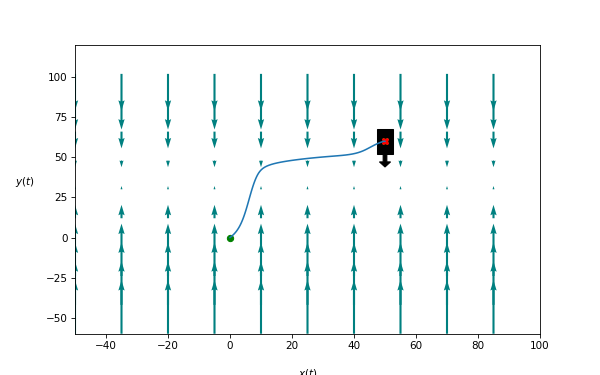

<IPython.core.display.Javascript object>


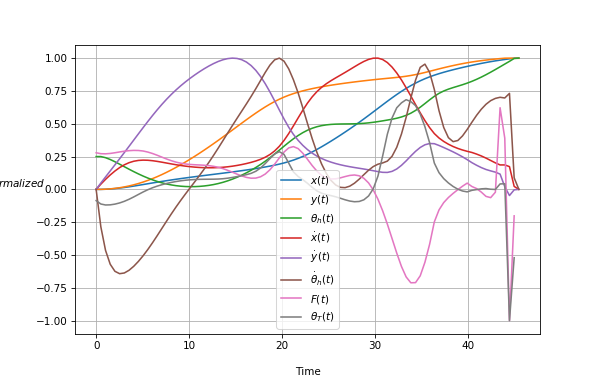

In [104]:

boat = create_boat(1)

# OPTIMIZE AND PLOT TRAJECTORY
if run_trajectory_optimization:
    
    solver = IpoptSolver()
    
    # solve without current first
    prog, opt_state, opt_thrust = formulate_optimization(map_name)
    traj_guess, thrust_guess = get_initial_guess(start, target, duration, time_interval)
    prog.SetInitialGuess(opt_state, traj_guess)
    prog.SetInitialGuess(opt_thrust, thrust_guess)
    traj_result = solver.Solve(prog)
    if not traj_result.is_success():
        infeasible = GetInfeasibleConstraints(prog, traj_result)
        print("Infeasible Optimization")
        for constraint in infeasible:
            print(constraint)
    else:
        print("Optimization Success")
        optimal_states = traj_result.GetSolution(opt_state)
        optimal_thrust = traj_result.GetSolution(opt_thrust)
    
    x_opt, y_opt, th_opt, x_dot_opt, y_dot_opt, th_dot_opt = optimal_states.T
    metric_times = np.linspace(0, len(x_opt)*time_interval, len(x_opt))
    animate_env(x_opt, y_opt, th_opt, x_dot_opt, y_dot_opt, th_dot_opt, metric_times, boat, obstacles, frame_skip=5)
    plt.figure(2)
    plot_boat_state_and_thrust(optimal_states, # plot optimization metrics
                               optimal_thrust,
                               metric_times,
                               plot=metric_switches,
                               normalize=True) 

# SIMULATE AND PLOT TRAJECTORY
if run_simulation:
    logger = simulate(start, [0, 0], boat, None, duration)
    x_sim, y_sim, th_sim, x_dot_sim, y_dot_sim, th_dot_sim = logger.data()[:6]
    metric_times = logger.sample_times()
    animate_env(x_sim, y_sim, th_sim, x_dot_sim, y_dot_sim, th_dot_sim, metric_times, boat, obstacles, frame_skip=50)
